# **What is Capsule Networks?**

Capsule Networks (CapsNet) are the networks that are able to fetch spatial information and more important features so as to overcome the loss of information that is seen in pooling operations. Let us see what is the difference between a capsule and a neuron. Capsule gives us a vector as an output that has a direction. For example, if you are changing the orientation of the image then the vector will also get moved in that same direction whereas the output of a neuron is a scalar quantity that does not tell anything about the direction.

To read about it more, please refer [this](https://analyticsindiamag.com/understanding-capsule-net-with-its-implementation-in-computer-vision/) article.

# **How to build a capsule network?**

First, we need to define the libraries that are required. Use the below code snippet to import the libraries and import the dataset. The dataset is famous Handwritten digits data that has digits from 0-9.

In [ ]:
!python -m pip install pip --upgrade --user -q --no-warn-script-location
!python -m pip install numpy pandas seaborn matplotlib scipy statsmodels sklearn nltk gensim tensorflow keras torch torchvision \
    tqdm scikit-image pillow --user -q --no-warn-script-location


import IPython
IPython.Application.instance().kernel.do_shutdown(True)


In [2]:
import numpy as np
import tensorflow as tf

import tensorflow_datasets
mnist = tensorflow_datasets.load('mnist')

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


After importing the required libraries let add the first input layer that will take the image. We have created a placeholder keeping batch as none with 28×28 pixels and channel as 1. Then we have started the definition of the capsule by defining the first two convents layer after that we have reshaped the output coming to the 2nd ConvNet layer to get the vector of 8D that gives the primary capsule output. The 2nd ConvNet layer contains 32*8 (256) feature maps. Due to which the output shape of the 2nd convent layer is (batch_size, 6 , 6 , 256).  

In [19]:
tf.compat.v1.disable_eager_execution()
input_image = tf.compat.v1.placeholder(shape = [None,28,28,1], dtype = tf.float32)
conv1 = tf.keras.layers.Conv2D(input_image, kernel_size=9,padding="none")
conv1 = tf.keras.layers.Conv2D(activation= 'relu')
conv2 = tf.keras.layers.Conv2D(input_image, 256, kernel_size = 9, stride=2,padding="none")
conv2 = tf.keras.layers.Conv2D(activation= 'relu')
capsule_1= tf.reshape(conv2,[-1,1152,8]) 

ValueError: ignored

In [14]:
help(tf.keras.layers.Conv2D)

Help on class Conv2D in module tensorflow.python.keras.layers.convolutional:

class Conv2D(Conv)
 |  Conv2D(*args, **kwargs)
 |  
 |  2D convolution layer (e.g. spatial convolution over images).
 |  
 |  This layer creates a convolution kernel that is convolved
 |  with the layer input to produce a tensor of
 |  outputs. If `use_bias` is True,
 |  a bias vector is created and added to the outputs. Finally, if
 |  `activation` is not `None`, it is applied to the outputs as well.
 |  
 |  When using this layer as the first layer in a model,
 |  provide the keyword argument `input_shape`
 |  (tuple of integers or `None`, does not include the sample axis),
 |  e.g. `input_shape=(128, 128, 3)` for 128x128 RGB pictures
 |  in `data_format="channels_last"`. You can use `None` when
 |  a dimension has variable size.
 |  
 |  Examples:
 |  
 |  >>> # The inputs are 28x28 RGB images with `channels_last` and the batch
 |  >>> # size is 4.
 |  >>> input_shape = (4, 28, 28, 3)
 |  >>> x = tf.random

After this we have defined the squash function referring to the paper that will squash all these vectors along the defined axis and then we have passed each capsule to this squash function. 

In [ ]:
def squash(s, name=None): 
  with tf.name_scope(name, default_name="squash"): 
  squared_norm = tf.reduce_sum(tf.square(s), axis=-1,     keep_dims=True)
  safe_norm = tf.sqrt(squared_norm + 1e-7)
  squash_factor = squared_norm / (1. + squared_norm) unit_vector = s / safe_norm return squash_factor * unit_vector
  caps1_out = squash(capsule_1)

After this, we define the digit capsule which is a total of 10 in number that outputs 16-dimensional vectors. Let us see how to compute this digit capsule. So, the first step is to compute the predicted output vectors since the second layer is connected to the first layer and we will predict one output for each pair of first and second layer capsules. By making use of the first primary capsule we can predict the output of the first digit capsule. This is done for all the digit capsules using the first primary capsule. Once it is computed we go for the second primary capsule output and compute the digit capsule in a similar fashion. The shape of the first array and second array is  (1152, 10, 16, 8), (1152, 10, 8, 1). The second array should contain 10 identical vectors. To do so we will use the tf.tile() function. Considering batch size to be 32, the network would make predictions for these 32 simultaneously. Therefore the shape of the first array will be (32, 1152,10,16,8) and the shape of the second array would be (32,1152,10,8,1). 

In [ ]:
W_init = tf.random_normal(shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims), stddev=init_sigma, dtype=tf.float32, name="W_init") 
W = tf.Variable(W_init, name="W")

batch_size = tf.shape(X)[0] W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

We need to create an array of shape (32,1152,10,8,1) that holds the outputs of the first layer capsules, repeated 10 times so we will first enlarge it to get an array of the same shape after which it can iterate or 10 times along the third dimension.

In [ ]:
caps1_output_enlarge = tf.expand_dims(caps1_output, -1)
caps1_output_tile = tf.expand_dims(caps1_output_expanded)
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1])

print(W_tiled)
print(caps1_output_tiled)


As discussed before now will take the product of both the array and check the shape.

In [ ]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled)
print(caps2_predicted)

After this, we will go to the next step that is routing, use the below code snippet to perform 2 round routing and after that, we will define the placeholder for the label. Below image represents the routing algorithm that has been taken from the original paper.

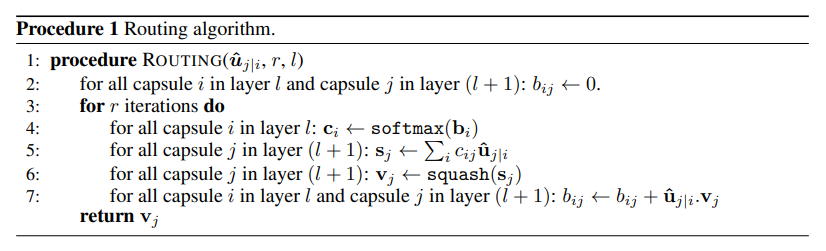

In [ ]:
#Round 1 Routing: 


raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1], dtype=np.float32, name="raw_weights")

routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

weighted_predictions = tf.multiply(routing_weights, caps2_predicted, name="weighted_predictions") weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True, name="weighted_sum")


#Round 2 Routing: 


caps2_output_round_1_tiled = tf.tile( caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1], name="caps2_output_round_1_tiled")

agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled, transpose_a=True, name="agreement")

raw_weights_round_2 = tf.add(raw_weights, agreement, name="raw_weights_round_2")

routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2, dim=2, name="routing_weights_round_2")

weighted_predictions_round_2 = tf.multiply(routing_weights_round_2, caps2_predicted, name="weighted_predictions_round_2") 

weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2, axis=1, keep_dims=True, name="weighted_sum_round_2") 

caps2_output_round_2 = squash(weighted_sum_round_2, axis=-2, name="caps2_output_round_2")


 y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

After computing the routing and placeholder for the label we will define the margin loss that has been mentioned in the original paper to identify two or more unalike digits each image. After that, we have defined the values and did encoding for the labels. In addition to that for output capsule, we have calculated the norm and after that, we have reshaped it to get a matrix of shape (batch size, outputs). After getting the matrix we have computed the loss for each digit and computed the final loss by taking mean. We have assigned the values of m_plus, m_minus and lambda as mentioned in the original paper stated below.

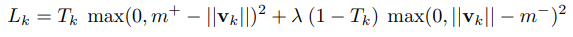

In [ ]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5 

T = tf.one_hot(y, depth=caps2_n_caps, name="T")

caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True, name="caps2_output_norm")

present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm), name="present_error_raw")

present_error = tf.reshape(present_error_raw, shape=(-1, 10), name="present_error")

absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus), name="absent_error_raw")

absent_error = tf.reshape(absent_error_raw, shape=(-1, 10), name="absent_error")

L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error, name="L")

margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

After defining the margin loss we now define the decoder part of the network that contains 3 fully connected layers that are responsible for reconstructing the images using the features and information that can be passed in the form of a vector by the encoder. After doing the reconstruction part we will define the decoder and computed reconstruction loss. At last, we have calculated the final loss by merging margin loss and reconstruction loss. The code of the same has been shown below. 

In [ ]:
mask_with_labels=tf.placeholder_with_default(False,shape=(),name="mask_with_labels")
reconstruction_targets = tf.cond(mask_with_labels, lambda: y, lambda: y_pred) 

Reconstruction_mask=tf.one_hot(reconstruction_targets,depth=caps2_n_caps,name="reconstruction_mask")

reconstruction_mask_reshaped=tf.reshape(reconstruction_mask,[-1,1,caps2_n_caps, 1, 1], name="reconstruction_mask_reshaped")

caps2_output_masked=tf.multiply(caps2_output,reconstruction_mask_reshaped,name="caps2_output_masked")

decoder_input=tf.reshape(caps2_output_masked,[-1,caps2_n_caps*caps2_n_dims], name="decoder_input")


With tf.name_scope("decoder"): 

hidden1=tf.layers.dense(decoder_input,512,activation=’relu’,name="hidden1")
          hidden2 = tf.layers.dense(hidden1,1024, activation=’relu’, name="hidden2") 
decoder_output=tf.layers.dense(hidden2,28X28,activation=’sigmoid’,name="decoder_output")


X_flat = tf.reshape(X, [-1, n_output], name="X_flat")

squared_difference=tf.square(X_flat-decoder_output,name="squared_difference") reconstruction_loss=tf.reduce_mean(squared_difference,name="reconstruction_loss")

loss = tf.add(margin_loss, 0.001 * reconstruction_loss, name="loss")

Now the final step is to train the capsule network and compute the accuracy and loss. We will be training the network for 10 epochs with a batch size of 32. After 4 epochs the accuracy has reached to 99.4%. 

In [ ]:
n_epochs = 10
batch_size = 32
with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val)

After training, we will evaluate the model by defining a function that computes the validation accuracy and loss. We receive the validation accuracy to be 99.53% with a loss of 0.006.

In [ ]:
n_iterations_test = mnist.test.num_examples
loss_tests = []
acc_tests = []
for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

We then make predictions using the network. Use the below code to do the same.

In [ ]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")
plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
plt.show()

#**Related Articles:**

> * [Capsule Network](https://analyticsindiamag.com/understanding-capsule-net-with-its-implementation-in-computer-vision/)

> * [Face Attendance System](https://analyticsindiamag.com/a-complete-guide-on-building-a-face-attendance-system/)

> * [6 MNIST Image Dataset](https://analyticsindiamag.com/mnist/)

> * [Vision Transformers](https://analyticsindiamag.com/hands-on-vision-transformers-with-pytorch/)

> * [MONAI](https://analyticsindiamag.com/monai-datatsets-managers/)

> * [Guide to Pystiche](https://analyticsindiamag.com/pystiche/)